In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from lib import *

In [2]:
proteome = fasta_iter('/home/amayer/data/proteomes/uniprot-homosapiens-up000005640.fasta')

In [3]:
lens = []
for seq in proteome:
    lens.append(len(seq[1]))

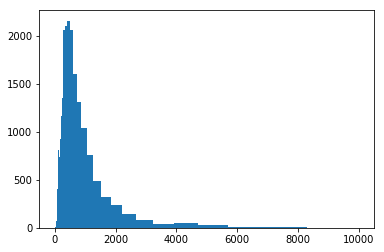

In [4]:
plt.hist(lens, bins=np.logspace(0, 4));

In [5]:
proteome = fasta_iter('/home/amayer/data/proteomes/uniprot-neisseriameningitdis-UP000000425.fasta')
len(np.unique(list(''.join([seq for h, seq in proteome]))))

20

In [6]:
k = 1
proteome = fasta_iter('/home/amayer/data/proteomes/uniprot-homosapiens-up000005640.fasta')
counter = defaultdict(int)
for header, sequence in proteome:
    count_kmers(sequence, k, counter=counter)
proteome = fasta_iter('/home/amayer/data/proteomes/uniprot-PlasmodiumFalciparum-up000001450.fasta')
counter2 = defaultdict(int)
for header, sequence in proteome:
    count_kmers(sequence, k, counter=counter2)

1.137079e+07, 6.400000e+07


Text(0.5,0,'k')

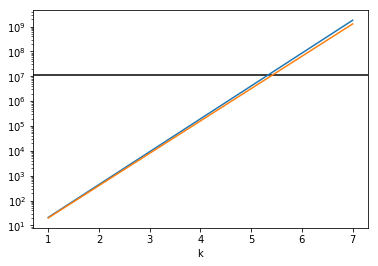

In [7]:
totalpeptides = np.sum(list(counter.values()))
print('%e, %e'%(totalpeptides, 20**6))
x = np.arange(1, 8)
plt.axhline(totalpeptides, color='k')
plt.plot(x, 21**x)
plt.plot(x, 20**x)
plt.yscale('log')
plt.xlabel('k')

In [8]:
2**scipy.stats.entropy(normalize(counter), base=2), 2**scipy.stats.entropy(normalize(counter2), base=2), 20**k

(18.09689067969323, 15.695846089968521, 20)

In [9]:
normalize(counter)

array([2.13200647e-02, 5.35581034e-02, 6.57225166e-02, 2.66593591e-02,
       6.31136391e-02, 4.73929210e-02, 7.10458050e-02, 5.72611000e-02,
       9.96074943e-02, 5.64265054e-02, 4.77053004e-02, 1.21853440e-02,
       8.32477705e-02, 5.96661217e-02, 3.64800479e-02, 3.58514197e-02,
       2.62400391e-02, 4.33489631e-02, 2.29733358e-02, 7.01908953e-02,
       3.25395129e-06])

Text(0,0.5,'frequency')

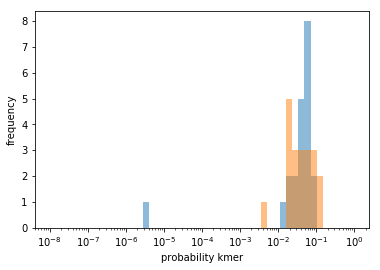

In [10]:
bins = np.logspace(-8, 0)
plt.hist(normalize(counter), bins=bins, alpha=.5)
plt.hist(normalize(counter2), bins=bins, alpha=.5)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('probability kmer')
plt.ylabel('frequency')

In [11]:
len(counter.values())/20**k, len(counter2.values())/20**k

(1.05, 1.0)

In [12]:
df = counter_to_df(counter)
df2 = counter_to_df(counter2)

In [13]:
dfmerged = pd.merge(df, df2, on='seq', suffixes=['_human', '_pathogen'])
dfmerged.to_csv('data.csv')

In [14]:
scipy.stats.entropy(dfmerged['freq_human'], dfmerged['freq_pathogen']), scipy.stats.entropy(dfmerged['freq_pathogen'], dfmerged['freq_human'])

(0.2346636095557455, 0.24755395990928056)

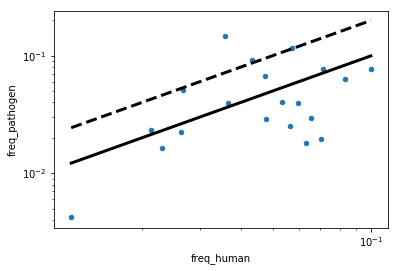

In [15]:
dfmerged.plot(x='freq_human', y='freq_pathogen', kind='scatter', logx=True, logy=True)
x = np.logspace(np.log10(np.amin(dfmerged['freq_human'])), np.log10(np.amax(dfmerged['freq_human'])))
plt.plot(x, x, 'k', lw=3)
plt.plot(x, x*2, '--k', lw=3)

/home/amayer/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/amayer/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


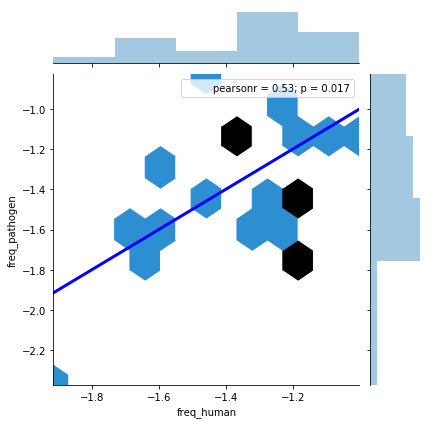

In [16]:
j = sns.jointplot(x=np.log10(dfmerged['freq_human']), y=np.log10(dfmerged['freq_pathogen']), kind="hex",
                 joint_kws=dict(gridsize=10));
x = np.logspace(np.log10(np.amin(dfmerged['freq_human'])), np.log10(np.amax(dfmerged['freq_human'])))
j.ax_joint.plot(np.log10(x), np.log10(x), 'b', lw=3)

In [17]:
dfmerged['fold'] = dfmerged['freq_pathogen']/dfmerged['freq_human']

In [18]:
dfmerged[dfmerged['freq_human']>2e-6].sort_values('fold', ascending=False)

,seq,freq_human,freq_pathogen,fold
15,N,0.035851,0.148551,4.143519
17,I,0.043349,0.091480,2.110320
7,K,0.057261,0.117360,2.049553
3,Y,0.026659,0.051345,1.925959
5,D,0.047393,0.066819,1.409900
14,F,0.036480,0.039934,1.094687
6,E,0.071046,0.077431,1.089879
0,M,0.021320,0.023123,1.084562
16,H,0.026240,0.022313,0.850324
8,L,0.099607,0.077088,0.773920


In [158]:
proteome = fasta_iter('/home/amayer/data/proteomes/uniprot-homosapiens-up000005640.fasta')
counter1 = defaultdict(int)
for header, sequence in proteome:
    count_kmers(sequence, 1, counter=counter1)
proteome = fasta_iter('/home/amayer/data/proteomes/uniprot-homosapiens-up000005640.fasta')
counter2 = defaultdict(int)
for header, sequence in proteome:
    #if np.random.rand() < 0.5:
    #    sequence = sequence[::-1]
    count_kmers(sequence, 2, counter=counter2)
    #count_kmers(sequence[::-1], 2, counter=counter2)

In [159]:
df1, df2 = counter_to_df(counter1), counter_to_df(counter2)
df1.set_index('seq', inplace=True)
df2 = df2[~df2['seq'].str.contains('U')]
df2['aa1'] = [s[0] for s in df2['seq']]
df2['aa2'] = [s[1] for s in df2['seq']]

In [160]:
df2['theory'] = [float(df1.loc[s[0]] * df1.loc[s[1]]) for s in df2['seq']]
df2['fold'] = np.log2(df2['freq']/df2['theory'])

In [161]:
dfmat = df2.pivot(columns='aa1', index='aa2')['fold']

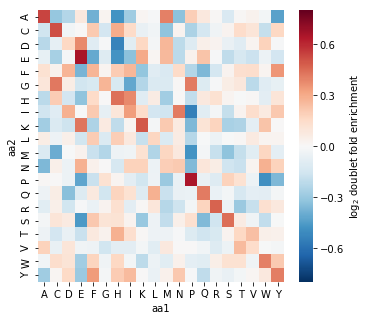

In [162]:
plt.figure(figsize=(5.5, 5))
sns.heatmap(dfmat, vmin=-0.8, vmax=0.8, cmap='RdBu_r', cbar_kws=dict(label='log$_2$ doublet fold enrichment'))

In [163]:
df2 = counter_to_df(counter2, norm=False)
df2 = df2[~df2['seq'].str.contains('U')]
df2['aa1'] = [s[0] for s in df2['seq']]
df2['aa2'] = [s[1] for s in df2['seq']]
counts = df2.pivot(columns='aa1', index='aa2')['count']

Text(0.5,0,'counts of AB')

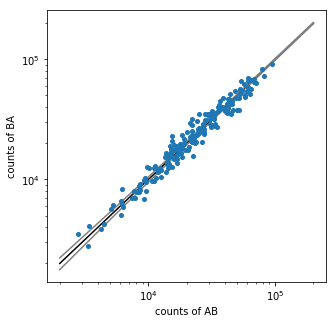

In [164]:
plt.figure(figsize=(5, 5))
x = np.linspace(2e3, 2e5)
plt.plot(x, x, 'k')
plt.plot(x, x+5*x**.5, 'gray')
plt.plot(x, x-5*x**.5, 'gray')
arr = np.ma.array(counts, mask=mask)
arrT = np.ma.array(counts.T, mask=mask)
plt.plot(arr.flatten(), arrT.flatten(), 'o', ms=4)
#plt.plot(x, 1.3*x, 'g')
#plt.plot(x, x/1.3, 'g')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('counts of BA')
plt.xlabel('counts of AB')

Text(28.5,0.5,'amino acid 2')

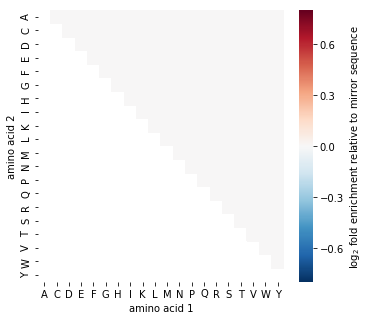

In [157]:
plt.figure(figsize=(5.5, 5))
fold = np.log2(counts/counts.T)
sns.heatmap(fold, mask=mask, vmin=-0.8, vmax=0.8, cmap='RdBu_r',
            cbar_kws=dict(label='log$_2$ fold enrichment relative to mirror sequence'))
plt.xlabel('amino acid 1')
plt.ylabel('amino acid 2')